In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.prediction.HVAE import ConditionalHierarchicalVAE
from utils.datasets import MNIST_SR
from utils.utils import gaussian_kl, PerceptualLoss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 512
scalefactor = 2

path = f"E:/GNN/experiments/trained_models/HVAE_MNIST_{scalefactor}x_prediction_perceptual.pth"

latent_dims = [64, 128, 256]
condition_dims = [32, 64]
channels = [16, 32, 64, 128]
cond_channels = [16, 32]
in_channels = 1
cond_base_width = 32 // scalefactor
model = ConditionalHierarchicalVAE(in_channels=in_channels,
                          #latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 32, 32), (1, in_channels, cond_base_width, cond_base_width)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                        Output Shape              Param #
ConditionalHierarchicalVAE                    [1, 1, 32, 32]            --
├─ConditionalHierarchicalEncoder: 1-1         [1, 64]                   --
│    └─Conv2d: 2-1                            [1, 16, 32, 32]           32
│    └─Conv2d: 2-2                            [1, 32, 16, 16]           8,224
│    └─Conv2d: 2-3                            [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-4                            [1, 128, 4, 4]            131,200
│    └─Linear: 2-5                            [1, 64]                   131,136
│    └─Linear: 2-6                            [1, 64]                   131,136
│    └─Linear: 2-7                            [1, 128]                  524,416
│    └─Linear: 2-8                            [1, 128]                  524,416
│    └─Linear: 2-9                            [1, 256]                  2,097,408
│    └─Linear: 2-10                           [1, 256]  

In [3]:
train_dataset = MNIST_SR(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = PerceptualLoss().to(device)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\UniProgramme\anaconda3\envs\isl_segmentation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
loss_list = []
recon_loss_list = []
kl_loss_list = []

In [6]:
kl_weight = 1000

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for HR, LR in train_loader:
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR)

        recon_loss = criterion(recon_imgs, HR)
        kl_loss = 0
        for mu, logvar in latents:
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        loss = recon_loss + kl_weight * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()    

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Perceptual Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Epoch [1/100] | Loss: 5829.685696 | Perceptual Loss: 683.531546 | KL Loss: 5.146154
Epoch [2/100] | Loss: 315.116813 | Perceptual Loss: 280.392047 | KL Loss: 0.034725
Epoch [3/100] | Loss: 296.674957 | Perceptual Loss: 144.331355 | KL Loss: 0.152344
Epoch [4/100] | Loss: 124.487677 | Perceptual Loss: 107.608414 | KL Loss: 0.016879
Epoch [5/100] | Loss: 100.021373 | Perceptual Loss: 89.817799 | KL Loss: 0.010204
Epoch [6/100] | Loss: 138.442680 | Perceptual Loss: 78.001302 | KL Loss: 0.060441
Epoch [7/100] | Loss: 75.844036 | Perceptual Loss: 69.655347 | KL Loss: 0.006189
Epoch [8/100] | Loss: 89.367891 | Perceptual Loss: 64.173643 | KL Loss: 0.025194
Epoch [9/100] | Loss: 83.284911 | Perceptual Loss: 59.830077 | KL Loss: 0.023455
Epoch [10/100] | Loss: 77.077005 | Perceptual Loss: 56.308561 | KL Loss: 0.020768
Epoch [11/100] | Loss: 57.074723 | Perceptual Loss: 53.757513 | KL Loss: 0.003317
Epoch [12/100] | Loss: 54.586384 | Perceptual Loss: 51.537513 | KL Loss: 0.003049
Epoch [13/100]

In [7]:
torch.save(model.state_dict(), path)

In [15]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

[]

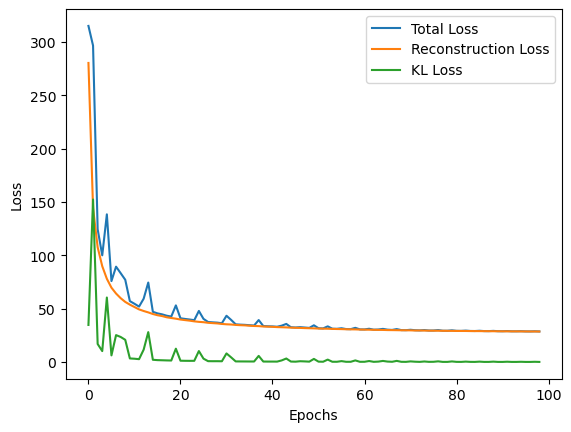

In [17]:
plt.plot(loss_list[1:], label='Total Loss')
plt.plot(recon_loss_list[1:], label='Reconstruction Loss')
plt.plot([l * kl_weight for l in kl_loss_list][1:], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [18]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [19]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

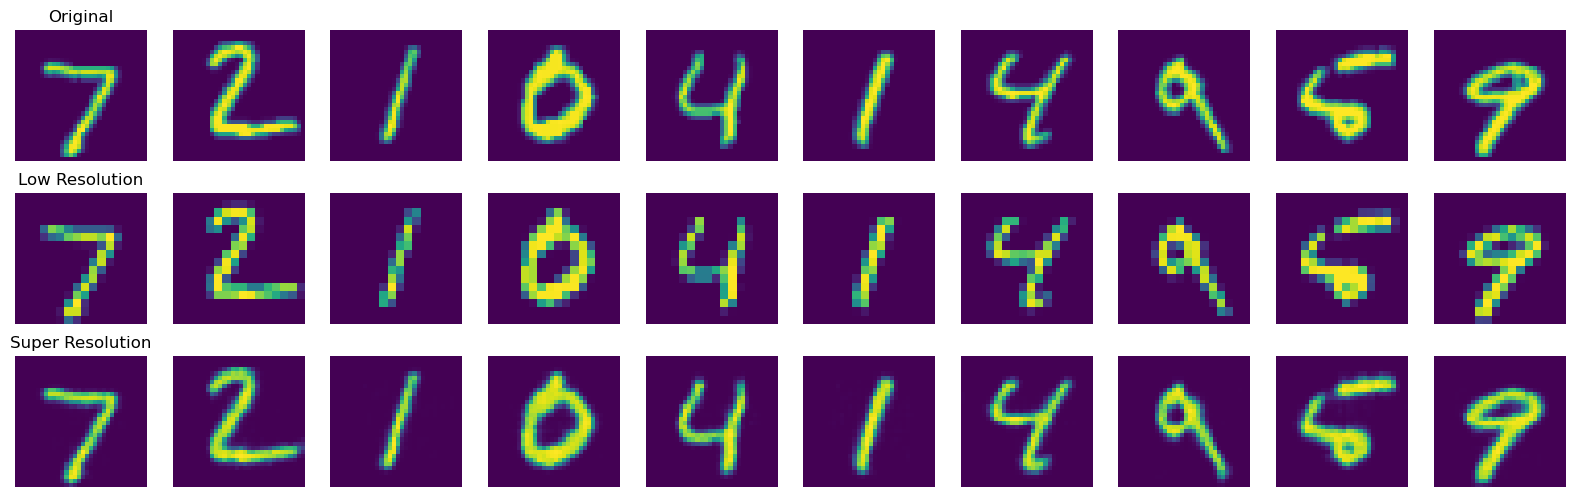

In [20]:
show_image(HR, LR, SR, 10)

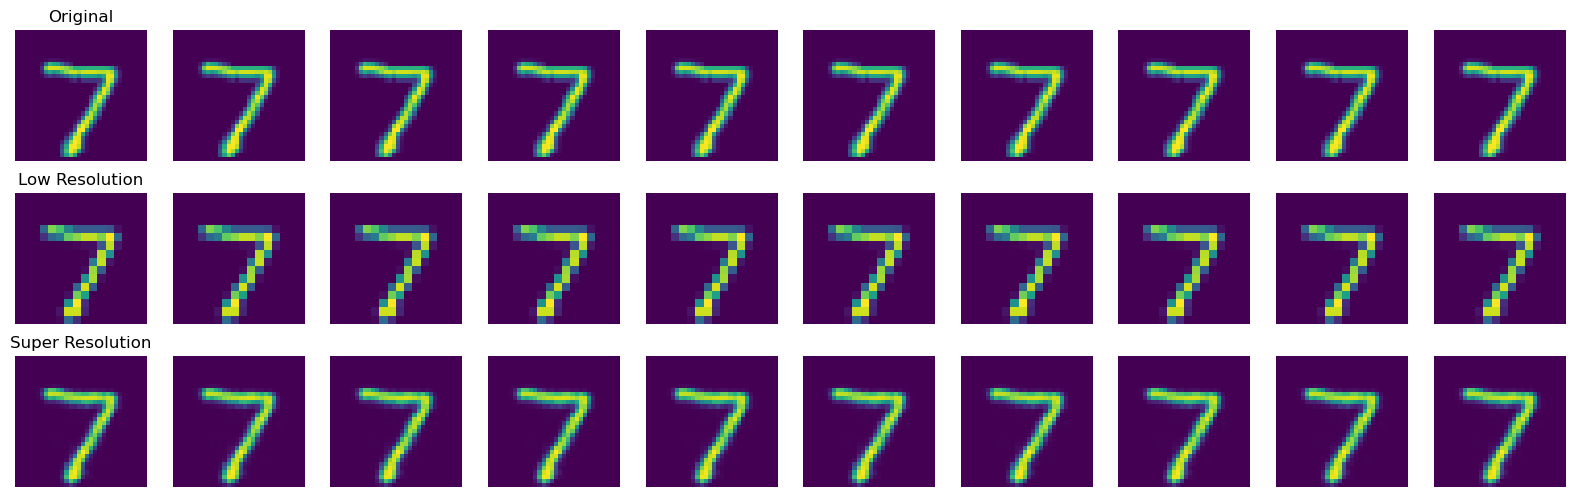

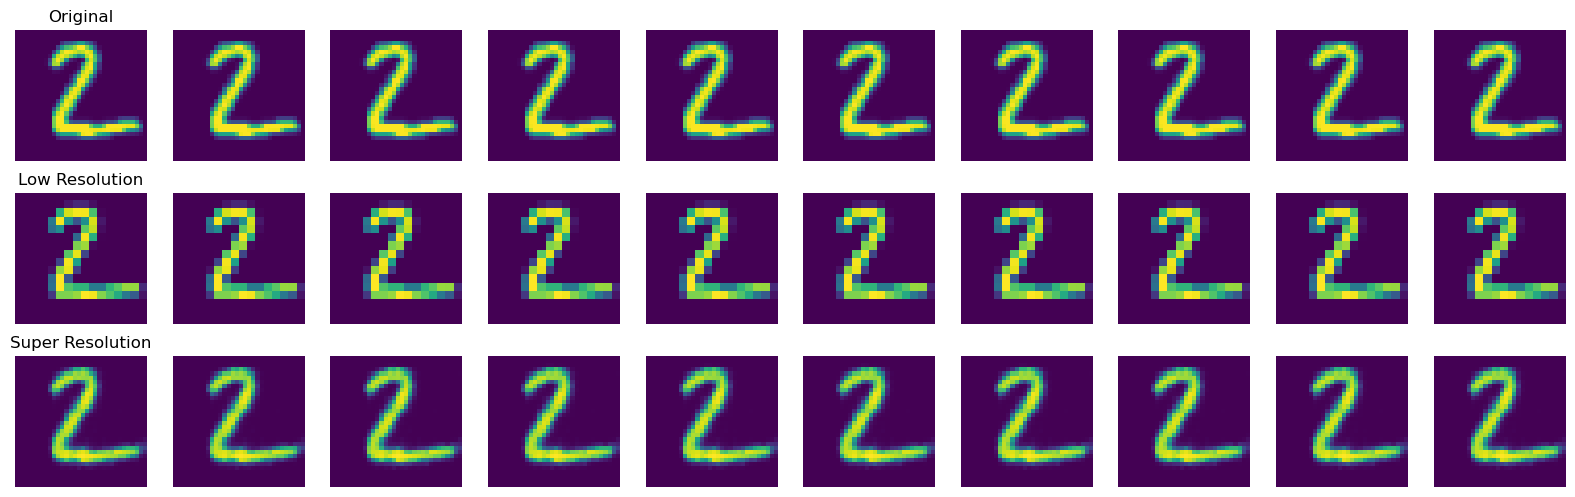

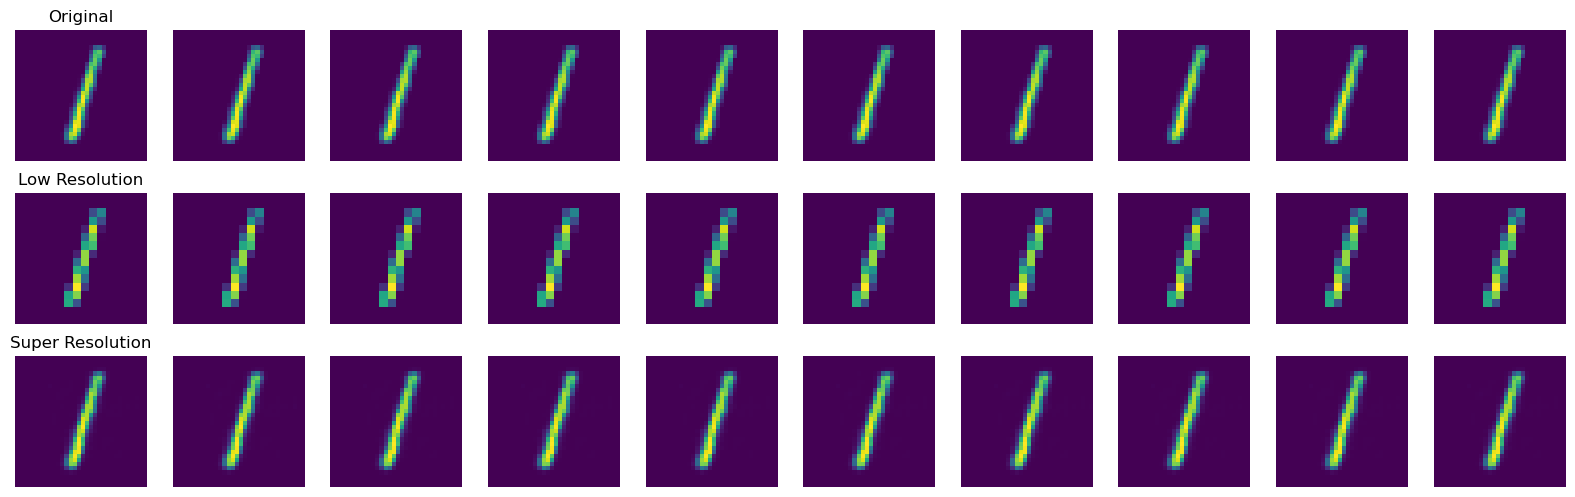

In [21]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [22]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: 28.26777458190918
SSIM: 0.9727017283439636
LPIPS: 0.016134358942508698
BRISQUE: 73.92914581298828
PSNR Consistency: 29.08086395263672
MSE Diversity: 7.80826195523332e-06
LPIPS Diversity: 0.00011972375962443493
